In [67]:
import numpy as np
import tensorflow as tf
import cv2
import os
import imghdr
import warnings
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, RootMeanSquaredError, SparseCategoricalAccuracy
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')

In [68]:

# configure how the library handles GPU memory allocation. 

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# When 'set_memory_growth' is set to True, TensorFlow will not allocate all available GPU memory upfront 
# but will grow the memory usage as needed by the application. This can be useful to avoid out-of-memory errors and 
#to allow multiple processes to share the same GPU.

In [69]:
data_dir = '../data'

file_ext = ['jpg','jpeg','png','bmp','gif']

classes = os.listdir(data_dir)
classes

['glioma', 'healthy', 'meningioma', 'pituitary']

In [70]:
for img_path in os.listdir(data_dir):
    for i, img in enumerate(os.listdir(os.path.join(data_dir, img_path))):
        try:
            image = cv2.imread(img)
            tip = imghdr.what(img)
            if tip not in file_ext:
                print(f'unsupported Image Format: {img}')
                break
        except Exception as e:
            print(f'Image Found {img}')
            break
            


Image Found glioma_1.jpg
Image Found healthy_1.jpg
Image Found meningioma_1.jpg
Image Found pituitary_1.jpg


### Data Initilization....

In [71]:
keras_data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256), batch_size=8)
keras_data

keras_data = keras_data.map(lambda x, y: (x/255, y)) # Normalizes the data pixels to range between 0 and 1 while leaving the labels (y) unchanged

batch = keras_data.as_numpy_iterator().next()

Found 7023 files belonging to 4 classes.


In [72]:
batch[0][0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [73]:
batch[1]

array([2, 1, 2, 1, 0, 1, 0, 2])

In [74]:
batch[1].shape

(8,)

In [75]:
batch[0].shape

(8, 256, 256, 3)

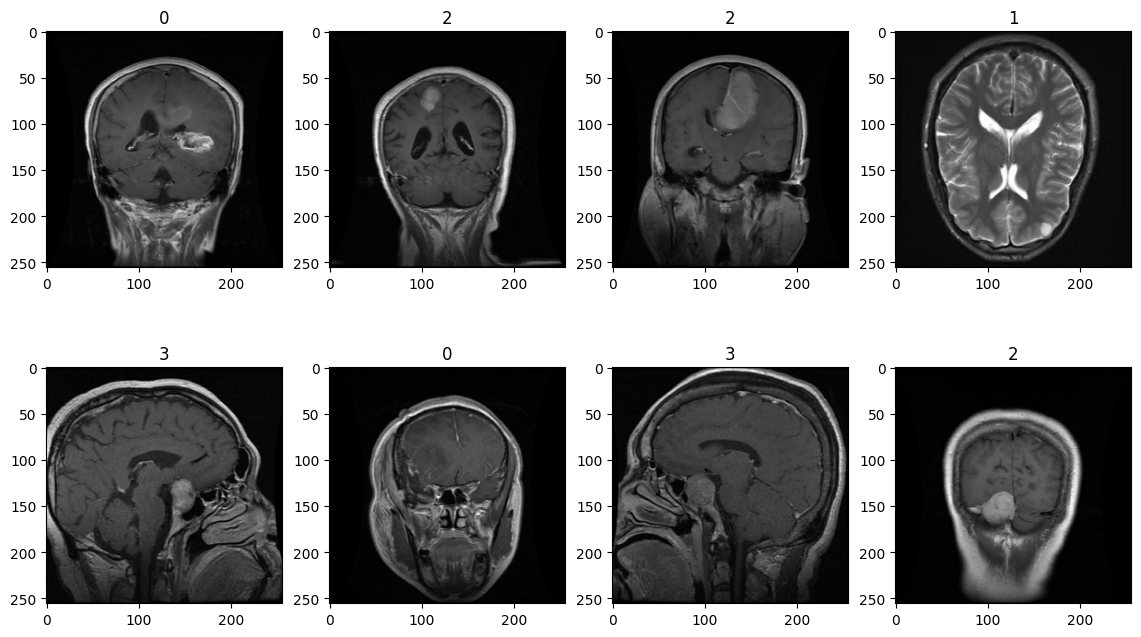

In [76]:
batch = keras_data.as_numpy_iterator().next() # for iteration of batch
fig, ax = plt.subplots(nrows=2, ncols=4, squeeze=False, figsize=(14, 8))
ax = ax.flatten()
for idx, imgs in enumerate(batch[0][0:8]):
    ax[idx].imshow(imgs)
    ax[idx].title.set_text(batch[1][idx])

### Splitting the Dataset

In [77]:
dataset_size = tf.data.experimental.cardinality(keras_data).numpy()
int(dataset_size)

878

In [78]:

target_size = (224, 224)
validation_split = 0.2
test_split = 0.1  # Proportion of the test set

# Calculate the sizes for splitting the dataset
train_size = int(dataset_size * (1 - validation_split - test_split))
validation_size = int(dataset_size * validation_split)
test_size = dataset_size - train_size - validation_size


In [79]:
print(f'Train size: {train_size} \nVal size: {validation_size} \nTest size: {test_size}')

Train size: 614 
Val size: 175 
Test size: 89


In [80]:
train1 = keras_data.take(train_size)
val1 = keras_data.skip(train_size).take(validation_size)
test1 = keras_data.skip(train_size + validation_size).take(test_size)

### Neural Network Model Building

In [81]:
resnet101 = tf.keras.applications.ResNet101(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(256, 256, 3)
)

model = Sequential()

model.add(resnet101) # add resnet101 as the base model

# adding custom layers
model.add(GlobalAveragePooling2D()) 

model.add(Dense(units=256, activation='relu')) # fully connected layers with 256 units
model.add(Dense(units=4, activation='softmax')) # output layer for multiclass classification

In [82]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape   ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ resnet101           │ ?              │ 42,658… │
│ (Functional)        │                │         │
├─────────────────────┼────────────────┼─────────┤
│ global_average_poo… │ ?              │       0 │
│ (GlobalAveragePool… │                │ (unbui… │
├─────────────────────┼────────────────┼─────────┤
│ dense_2 (Dense)     │ ?              │       0 │
│                     │                │ (unbui… │
├─────────────────────┼────────────────┼─────────┤
│ dense_3 (Dense)     │ ?              │       0 │
│                     │                │ (unbui… │
└─────────────────────┴────────────────┴─────────┘

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 42,552,832 (162.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [83]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # we've use sparse_categorical_crossentropy since the output of the target are One-hot Encoded [0, 1, 0, 0]
# wwe could have used 'categorical_crossentropy' if the target variables were integers [1, 2, 3, 4]

In [84]:
checkpoint = ModelCheckpoint('../model/brain-tumor-model.keras', save_best_only=True) # saves best performing model during training
early_stopping = EarlyStopping(patience=5, restore_best_weights=True) # stops training when model stops improving

In [85]:
logs = '../logs'

tensorboard_callbacks = tf.keras.callbacks.TensorBoard(logs) 

In [86]:
def is_image_file(file_path):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions)

def check_images_in_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not is_image_file(file_path):
                print(f"Unsupported image file format: {file_path}")
            else:
                try:
                    image = tf.io.read_file(file_path)
                    tf.image.decode_image(image, channels=3)
                except tf.errors.InvalidArgumentError:
                    print(f"Invalid image format for file: {file_path}")
                # os.remove(file_path)
                    

# Path to the directory containing images
directory_path = data_dir

# Check images in the directory
check_images_in_directory(directory_path)

In [87]:
history = model.fit(train1, epochs=5, callbacks=[checkpoint, early_stopping], validation_data=val1, shuffle=True)

Epoch 1/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 10441s 17s/step - accuracy: 0.5740 - loss: 1.1146 - val_accuracy: 0.2307 - val_loss: 4.7387
Epoch 2/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 10097s 16s/step - accuracy: 0.7880 - loss: 0.5672 - val_accuracy: 0.6600 - val_loss: 0.9999
Epoch 3/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 11711s 19s/step - accuracy: 0.8233 - loss: 0.4595 - val_accuracy: 0.5864 - val_loss: 1.1519
Epoch 4/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 11286s 18s/step - accuracy: 0.8518 - loss: 0.3923 - val_accuracy: 0.3407 - val_loss: 3.2604
Epoch 5/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 8206s 13s/step - accuracy: 0.8832 - loss: 0.3321 - val_accuracy: 0.7336 - val_loss: 1.1181


### Save the model

In [88]:
model.save(os.path.join('..\model', 'brain-tumor.h5'))

In [89]:
history.history

{'accuracy': [0.6325325965881348,
  0.7929560542106628,
  0.8395765423774719,
  0.8633957505226135,
  0.8874185681343079],
 'loss': [0.9107906818389893,
  0.5519033074378967,
  0.42848896980285645,
  0.3689645826816559,
  0.31587645411491394],
 'val_accuracy': [0.23071429133415222,
  0.6600000262260437,
  0.5864285826683044,
  0.3407142758369446,
  0.7335714101791382],
 'val_loss': [4.738700866699219,
  0.9998593330383301,
  1.1518726348876953,
  3.260390281677246,
  1.118054986000061]}

### Plot the performance

Text(0.5, 1.0, 'Model Training Accuracy \nvs Validation Accuracy')

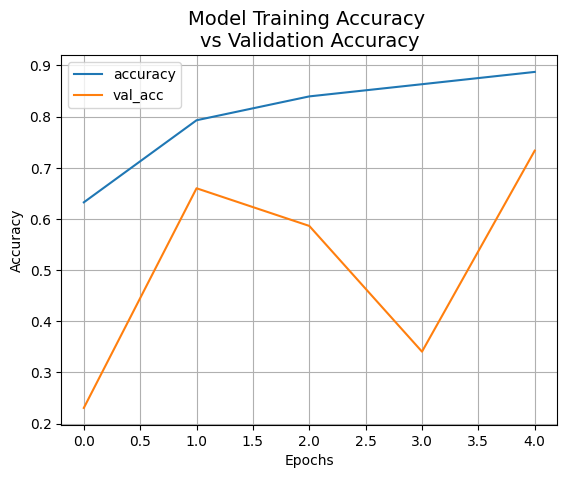

In [90]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Model Training Accuracy \nvs Validation Accuracy', fontsize=14)

Text(0.5, 1.0, 'Model Training Loss \nvs Validation Loss')

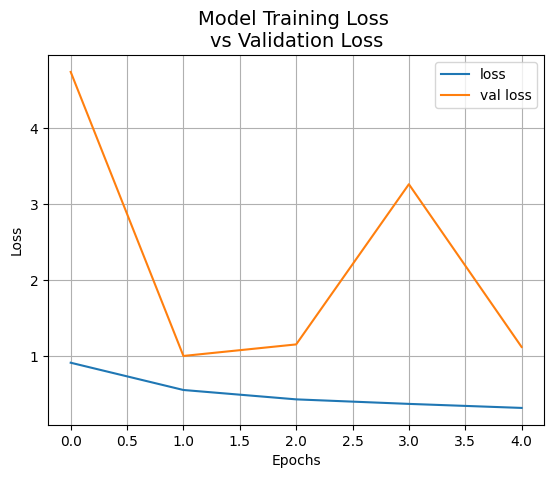

In [91]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.title('Model Training Loss \nvs Validation Loss', fontsize=14)

### Performance Evaluation

In [92]:
prec = Precision()
rmse = RootMeanSquaredError()
sparse = SparseCategoricalAccuracy()
rec = Recall()

for batch in test1.as_numpy_iterator():
    x, y = batch
    y_pred = model.predict(x)
    prec.update_state(y, y_pred)
    rmse.update_state(y, y_pred)
    sparse.update_state(y, y_pred)
    rec.update_state(y, y_pred)

#### Manual Testing

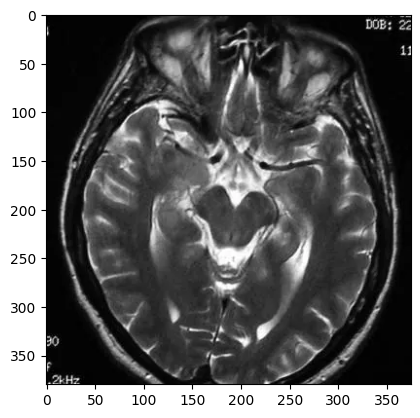

In [93]:
img = cv2.imread(r"D:\Downloads\pit1.webp")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [94]:
img_resize = tf.image.resize(img, (256, 256))

In [95]:
np.expand_dims(img_resize, 0).shape

(1, 256, 256, 3)

In [96]:
new_model = load_model('../model/brain-tumor.h5')

In [97]:
new_prediction = new_model.predict(np.expand_dims(img_resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step


In [98]:
new_prediction

array([[5.8984885e-04, 7.5473225e-01, 2.3884466e-01, 5.8332835e-03]],
      dtype=float32)

In [99]:
predicted_class = np.argmax(new_prediction)
predicted_class

1

In [100]:
class_names = ['glioma', 'healthy', 'meningioma', 'pituitary']
print("Predicted class:", class_names[predicted_class])

Predicted class: healthy
